**Alex Dehn // Adrian Gruszczynski // Adriana Pinto**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#guarantee fixed seeds for comparability
np.random.seed(42)
tf.random.set_random_seed(42)

In [3]:
graph = tf.Graph()

In [4]:
# this line opens a context in which all following tensorflow operations are bound to the graph
with graph.as_default():
    session = tf.Session()

In [5]:
def ground_truth(x):
    return np.sin(x) - np.cos(1.9 * x)

In [6]:
n_samples = 30
noise_level = 0.3

xs_data = np.random.uniform(low=-np.pi, high=np.pi, size=(n_samples, 1))
ys_data = ground_truth(xs_data) + noise_level * np.random.normal(size=xs_data.shape)

In [7]:
xs = np.linspace(-np.pi, np.pi, 300)[:, np.newaxis]
ys = ground_truth(xs)

# Part 3: Homework - kernel ridge regression

## Overfitting and underfitting

### Task 1:
After filling the gaps in the previous section, run on `1`, `2`, `80` RBFs and observe the behavior of the fit.

In [8]:
# Wrap the model as a class
class KernelRidgeRegression:
    def __init__(self, data, target, rbf):
        embedded_input = self.rbf_expansion(data, -3, 3, rbf)
        with tf.variable_scope("kernel_trick_1aa", reuse=tf.AUTO_REUSE):
            weights = tf.get_variable(name="weights", shape=(1, rbf), dtype=tf.float32,
                                     initializer=tf.contrib.slim.xavier_initializer(), validate_shape=False)
            biases = tf.get_variable(name="bias", shape=(1, 1), dtype=tf.float32,
                                   initializer=tf.initializers.zeros())
        self.model_output = tf.tensordot(embedded_input, tf.transpose(weights), axes=1) + biases
        self.loss = tf.losses.mean_squared_error(target, self.model_output)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-3)
        self.optimization_step = optimizer.minimize(self.loss)

    @staticmethod
    def rbf_expansion(inputs, low: float, high: float, count: int):
        low, high, count = float(low), float(high), int(count)
        assert high > low
        spacing = (high - low) / count
        gamma = 1. / spacing

        centers = tf.cast(tf.lin_space(low, high, count), inputs.dtype)
        return tf.exp(-gamma * tf.square(inputs - centers))

    def predict(self):
        return self.model_output
    
    def optimize(self):
        return self.optimization_step
    
    def loss(self):
        return self.losses

In [9]:
# Provide a method to run model with different parameters
def run(n_iteration_steps, n_basis_functions):
    with tf.Graph().as_default():
        data_input = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="data_input")
        target_input = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="target_input")


        model = KernelRidgeRegression(data_input, target_input, _n_basis_functions)

        session = tf.Session()
        initializer = tf.global_variables_initializer()
        session.run(initializer)
        losses = []

        for i in range(n_iteration_steps):

            # we can evaluate multiple nodes at the same time, by putting them in a container like
            # a python list or tuple
            current_loss, _ = session.run([model.loss, model.optimization_step], feed_dict={
                data_input: xs_data,
                target_input: ys_data
            })

            losses.append(current_loss)

            # we don't want to print the loss at each iteration
            if i % 2000 == 0:
                print(f"iteration: {i}, loss: {current_loss}")

        predictions = session.run(model.model_output, feed_dict={data_input: xs})
        predictions_on_samples = session.run(model.model_output, feed_dict={data_input: xs_data})
        session.close()
        tf.reset_default_graph
        plot(xs, ys, predictions, predictions_on_samples, '# basis functions {}'.format(n_basis_functions))

In [10]:
def plot(xs, ys, predictions, prediction_on_samples, title):
    plt.plot(xs, ys, label="ground truth")
    plt.plot(xs, predictions, c="r", label="predictions")
    plt.scatter(xs_data, ys_data, marker="x", c="g", label="samples")
    plt.legend()
    plt.title(title)
    plt.show()

iteration: 0, loss: 1.0453273057937622
iteration: 2000, loss: 0.6396146416664124
iteration: 4000, loss: 0.6327707767486572
iteration: 6000, loss: 0.6299619078636169
iteration: 8000, loss: 0.6288053393363953
iteration: 10000, loss: 0.6283291578292847
iteration: 12000, loss: 0.6281330585479736
iteration: 14000, loss: 0.6280523538589478
iteration: 16000, loss: 0.6280190944671631
iteration: 18000, loss: 0.62800532579422


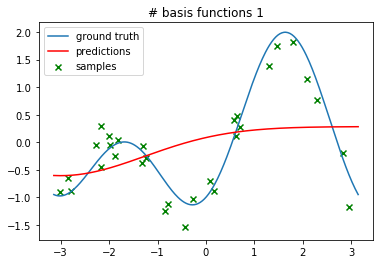

In [12]:
_n_basis_functions = 1
n_iteration_steps = 20000

run(n_iteration_steps, _n_basis_functions)

iteration: 0, loss: 0.9140169024467468
iteration: 2000, loss: 0.7198812961578369
iteration: 4000, loss: 0.6783536672592163
iteration: 6000, loss: 0.6563705801963806
iteration: 8000, loss: 0.6426076889038086
iteration: 10000, loss: 0.6333096027374268
iteration: 12000, loss: 0.6268431544303894
iteration: 14000, loss: 0.6222994327545166
iteration: 16000, loss: 0.6190953850746155
iteration: 18000, loss: 0.6168331503868103


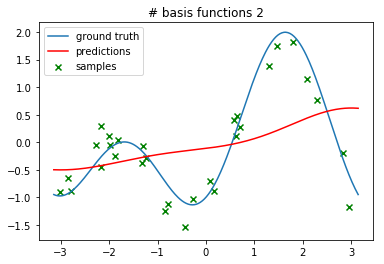

In [13]:
_n_basis_functions = 2
n_iteration_steps = 20000

run(n_iteration_steps, _n_basis_functions)

iteration: 0, loss: 0.7321544885635376
iteration: 2000, loss: 0.08729922026395798
iteration: 4000, loss: 0.045321688055992126
iteration: 6000, loss: 0.04042145982384682
iteration: 8000, loss: 0.03846829757094383
iteration: 10000, loss: 0.0369594432413578
iteration: 12000, loss: 0.0356457456946373
iteration: 14000, loss: 0.03447640687227249
iteration: 16000, loss: 0.03342690318822861
iteration: 18000, loss: 0.03247959911823273


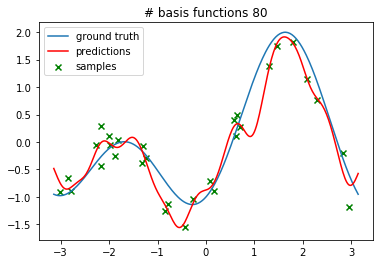

In [14]:
_n_basis_functions = 80
n_iteration_steps = 20000

run(n_iteration_steps, _n_basis_functions)

Higher RBF values are more prone to overfitting as shown above.

### Task 2:

The variance of the solution can be decreased by biasing the minimization problem into a direction where the degrees of freedom are kept small, effectively improving the condition of the problem. One particular way of achieving this is called $\ell_2$ or Ridge regularizaion, where the weights are penalized with their $\ell_2$ norm. In particular:

$$a
W^* = \arg\min_{W} \tfrac{1}{N} \sum_{n=1}^{N}(f_{W}(x_i) - y_i)^{2} + \lambda \| W \|_2^2
$$

with $\| x \|_2 = (x_1^2 + \ldots + x_d^2)^{\tfrac{1}{2}}$ and for an appropriate choice of $\lambda\geq 0$.

Implement $\ell_2$ regularization for the RBF embedded fitting problem. A useful method to achieve this is [tf.math.reduce_sum](https://www.tensorflow.org/api_docs/python/tf/math/reduce_sum).ipynb_checkpoints/

In [15]:
# Wrap the model as a class
class KernelRidgeRegressionL2:
    def __init__(self, data, target, rbf, _lambda):
        embedded_input = self.rbf_expansion(data, -3, 3, rbf)
        with tf.variable_scope("kernel_l2", reuse=tf.AUTO_REUSE):
            weight = tf.get_variable(name="weights", shape=(1, rbf), dtype=tf.float32,
                                     initializer=tf.contrib.slim.xavier_initializer(),
                                     regularizer=tf.contrib.layers.l2_regularizer(_lambda))
            bias = tf.get_variable(name="bias", shape=(1, 1), dtype=tf.float32,
                                   initializer=tf.initializers.zeros())
        self.model_output = tf.tensordot(embedded_input, tf.transpose(weight), axes=1) + bias
        reg_loss = tf.math.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
        self.l2_loss = tf.losses.mean_squared_error(target, self.model_output) + reg_loss
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-3)
        self.optimization_step = optimizer.minimize(self.l2_loss)

    @staticmethod
    def rbf_expansion(inputs, low: float, high: float, count: int):
        low, high, count = float(low), float(high), int(count)
        assert high > low
        spacing = (high - low) / count
        gamma = 1. / spacing

        centers = tf.cast(tf.lin_space(low, high, count), inputs.dtype)
        return tf.exp(-gamma * tf.square(inputs - centers))

    def predict(self):
        return self.model_output

    def optimize(self):
        return self.optimization_step

    def loss(self):
        return self.l2_loss

In [16]:
# Provide a method to run model with different parameters
def run(n_iteration_steps, n_basis_functions, _lambda):
    with tf.Graph().as_default():
        data_input = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="data_input")
        target_input = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="target_input")


        model = KernelRidgeRegressionL2(data_input, target_input, _n_basis_functions, _lambda)

        session = tf.Session()
        initializer = tf.global_variables_initializer()
        session.run(initializer)
        losses = []

        for i in range(n_iteration_steps):

            # we can evaluate multiple nodes at the same time, by putting them in a container like
            # a python list or tuple
            current_loss, _ = session.run([model.l2_loss, model.optimization_step], feed_dict={
                data_input: xs_data,
                target_input: ys_data
            })

            losses.append(current_loss)

            # we don't want to print the loss at each iteration
            if i % 2000 == 0:
                print(f"iteration: {i}, loss: {current_loss}")

        predictions = session.run(model.model_output, feed_dict={data_input: xs})
        predictions_on_samples = session.run(model.model_output, feed_dict={data_input: xs_data})
        session.close()
        tf.reset_default_graph
        plot(xs, ys, predictions, predictions_on_samples, 'Lambda value: {}'.format(_lambda))

### Test the model with different lambda hyperparameters

INFO:tensorflow:Scale of 0 disables regularizer.
iteration: 0, loss: 0.8104457259178162
iteration: 2000, loss: 0.07435257732868195
iteration: 4000, loss: 0.03815257176756859
iteration: 6000, loss: 0.034591544419527054
iteration: 8000, loss: 0.033306170254945755
iteration: 10000, loss: 0.032345596700906754
iteration: 12000, loss: 0.03150806948542595
iteration: 14000, loss: 0.030748851597309113
iteration: 16000, loss: 0.0300503671169281
iteration: 18000, loss: 0.029403138905763626


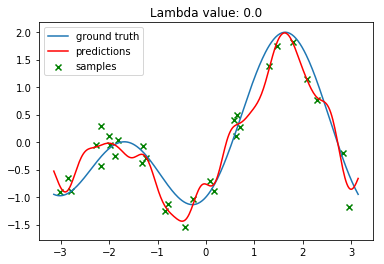

In [18]:
_n_basis_functions = 80
n_iteration_steps = 20000
_lambda = .0

run(n_iteration_steps, _n_basis_functions, _lambda)

iteration: 0, loss: 2.021528720855713
iteration: 2000, loss: 0.4644745886325836
iteration: 4000, loss: 0.4462948441505432
iteration: 6000, loss: 0.44593489170074463
iteration: 8000, loss: 0.4459233582019806
iteration: 10000, loss: 0.4459226429462433
iteration: 12000, loss: 0.4459225535392761
iteration: 14000, loss: 0.4459225535392761
iteration: 16000, loss: 0.4459225535392761
iteration: 18000, loss: 0.4459225833415985


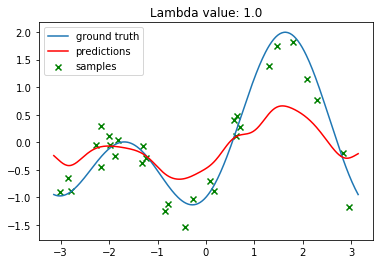

In [20]:
_n_basis_functions = 80
n_iteration_steps = 20000
_lambda = 1.0

run(n_iteration_steps, _n_basis_functions, _lambda)

iteration: 0, loss: 0.8771159648895264
iteration: 2000, loss: 0.2193087637424469
iteration: 4000, loss: 0.17148281633853912
iteration: 6000, loss: 0.15490344166755676
iteration: 8000, loss: 0.14481234550476074
iteration: 10000, loss: 0.13823342323303223
iteration: 12000, loss: 0.1338977813720703
iteration: 14000, loss: 0.131027489900589
iteration: 16000, loss: 0.1291206032037735
iteration: 18000, loss: 0.12784981727600098


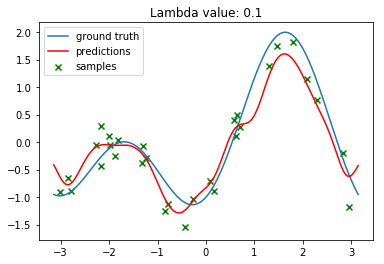

In [21]:
_n_basis_functions = 80
n_iteration_steps = 20000
_lambda = 0.1

run(n_iteration_steps, _n_basis_functions, _lambda)

iteration: 0, loss: 0.8926371335983276
iteration: 2000, loss: 0.10690111666917801
iteration: 4000, loss: 0.05690021812915802
iteration: 6000, loss: 0.050230905413627625
iteration: 8000, loss: 0.04706951603293419
iteration: 10000, loss: 0.04460706561803818
iteration: 12000, loss: 0.04250497370958328
iteration: 14000, loss: 0.040662284940481186
iteration: 16000, loss: 0.03902602940797806
iteration: 18000, loss: 0.03756145015358925


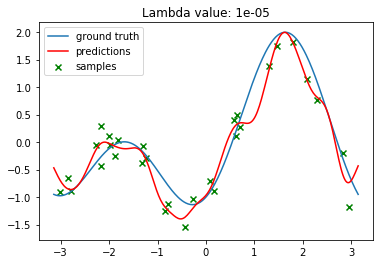

In [22]:
_n_basis_functions = 80
n_iteration_steps = 20000
_lambda = 0.00001

run(n_iteration_steps, _n_basis_functions, _lambda)

Lower lambda values support overfitting, whereas higher values reduce it.

### Task 3:

You are given data from an unknown ground truth in the file `training_data.npz`.

Your task is to build a kernel ridge regression model that approximates the ground truth as close as possible, without overfitting on your data set.

__Hint:__ You can use `validation_data.npz` to validate whether your model might have overfitted on the training data. __But beware__: if you include the validation data in your training (or validate too much) then you will also overfit to it as well and you will not be able to extrapolate!

### Deliverables

1. Evaluate your model on the inputs given in the file `x_test.npy`.
2. Upload your model's prediction as a file `model_outputs.npy`.
3. Upload your notebook used for obtaining your results.

__Disclaimer__: we will take samples of your notebooks to see whether the model you have implemented matches the prediction data you submit. If we discover a mismatch that cannot be explained by floating point error or similar we will consider this homework as failed.

### Load data

In [23]:
training_data_x = np.load("task/x_train.npy")
training_data_y = np.load("task/y_train.npy")

validation_data_x = np.load("task/x_val.npy")
validation_data_y = np.load("task/y_val.npy")
test_data_x = np.load("task/x_test.npy")

In [ ]:
with tf.Graph().as_default():
    _lambda = 0.1
    _n_basis_functions = 80
    data_input = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="data_input")
    target_input = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="target_input")


    model = KernelRidgeRegressionL2(data_input, target_input, _n_basis_functions, _lambda)

    session = tf.Session()
    initializer = tf.global_variables_initializer()
    session.run(initializer)
    losses = []

    for i in range(n_iteration_steps):

        # we can evaluate multiple nodes at the same time, by putting them in a container like
        # a python list or tuple
        current_loss, _ = session.run([model.l2_loss, model.optimization_step], feed_dict={
            data_input: training_data_x,
            target_input: training_data_y
        })

        losses.append(current_loss)

        # we don't want to print the loss at each iteration
        if i % 2000 == 0:
            print(f"iteration: {i}, loss: {current_loss}")

    predictions_training = session.run(model.model_output, feed_dict={data_input: training_data_x})
    predictions_val = session.run(model.model_output, feed_dict={data_input: validation_data_x})
    predictions_test = session.run(model.model_output, feed_dict={data_input: test_data_x})
    np.save("model_outputs", predictions_test)
    session.close()
    tf.reset_default_graph

    plt.scatter(training_data_x, training_data_y, label="training data", marker='o')
    plt.scatter(training_data_x, predictions_training, c="r", label="predictions", marker='x')
    plt.title('Training accuracy')
    plt.show()
    
    plt.scatter(validation_data_x, validation_data_y, label="validation data", marker='o')
    plt.scatter(validation_data_x, predictions_val, c="r", label="predictions", marker='x')
    plt.title('Validation accuracy')
    plt.show()
    
    plt.scatter(test_data_x, predictions_test, label="test data", marker='x')
    plt.title('Test data prediction')
    plt.show()

iteration: 0, loss: 0.7561365365982056
iteration: 2000, loss: 0.47003069519996643
iteration: 4000, loss: 0.4320765733718872
iteration: 6000, loss: 0.41800564527511597
